In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langchain_huggingface import HuggingFaceEmbeddings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")


from google.cloud import bigquery;
%load_ext google.cloud.bigquery

client = bigquery.Client("som-nero-phi-jonc101")

pd.set_option('display.max_columns', None)

/Users/wenyuanchen/anaconda3/envs/sage_recommender/lib/python3.13/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


In [30]:
data_path = "/Users/wenyuanchen/Library/CloudStorage/Box-Box/ART_PerMessage_1_17_Updated.xlsx"
data_sample = pd.read_excel(data_path)  # or whatever number of rows you want # take around 6 minutes to run 
# data_sample["Patient Message"] = data_sample["Patient Message"].replace("<13><10>", "\n")
# data_sample["Actual Response Sent to Patient"] = data_sample["Actual Response Sent to Patient"].replace("<13><10>", "\n").fillna("No response")

In [96]:
data_sample.head()

,Source.Name,EOW ID,Reply to Patient EOW ID,WMG ID,Thread ID,Date Sent,Message Department,Department Specialty Title,Department Specialty Category,Reply to Patient Sender,Reply to Patient User Template,Reply to Patient User Licenses,Reply to Patient Provider Type,Message Sender,Recipient IDs,Recipient Names,Recipient Licenses,LLM Viewer IDs,LLM Viewer Names,LLM Viewer Licenses,Is Response Valid?,Prompt Sent to LLM,Suggested Response from LLM,Response If Used As Draft,Actual Response Sent to Patient,List of Strings Removed from Draft,List of Strings Added to Draft,Total Length of Removed Strings,Total Length of Added Strings,Length of Draft Unchanged,Subject,Time Spent Responding (sec),Time Spent Reading (sec),Draft Viewed By Pilot User,Draft Used By Pilot User,Command Executed,QuickAction Executed,Levenshtein Distance,Response Length,Draft Length,Prompt Length,Subject Length,Patient Message Length,Patient Message,LLM Feedback,LLM Feedback Deficiencies,LLM Feedback Comment,LLM Feedback User,Clinical Categories added by User,Non-Clinical Categories added by User,Non-Actionable Categories added by User,Clinical Categories added by System,Non-Clinical Categories added by System,Non-Actionable Categories added by System,Age at time of message,Sex Title,Sex Category,Gender Category,Gender Title,Race Title,Race Category,Ethnic Background Title,Ethnic Background Category,Ethnic Group Title,Ethnic Group Category,Financial Class Title,Financial Class Category,Active Coverages Title,Active Coverages Category,Preferred Language Title,Preferred Language Category,Need Interpreter? Title EPT-840,Need Interpreter? Cat EPT-840,Patient Has MyChart Proxies?,Completed Data Models,Message Position in Thread,Hours Between Current and Previous Message
0,LLMData_1.csv,901410967,NaN,92586871,255729942,2025-01-16,THORACIC ONCOLOGY,Oncology,24,NaN,NaN,NaN,NaN,"TRAN, TRI [ S0372371]",POOL 10419,CC THOR ONC MED CLINICAL,NaN,NaN,NaN,NaN,1,Act as if you are the Healthcare Provider who ...,"Hi Judy,<10><10>It's great to hear that Adam i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,RE:Labs,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,10045,7,298,"Hi Marilena,<13><10><13><10>I was asking more ...",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,59.0,Male,2.0,NaN,NaN,Asian,8,"Chinese, except Taiwanese",11,Non-Hispanic/Non-Latino,2.0,NaN,NaN,MANAGED CARE,101.0,English,132.0,No,2.0,0,NaN,1.0,NaN
1,LLMData_1.csv,901410953,NaN,92586638,255891686,2025-01-16,STANFORD PRIMARY CARE SANTA CLARA,Primary Care,125,NaN,NaN,NaN,NaN,"ROGACION, JOSE ANTONIO [ S0294361]",POOL 10849,SANTA CLARA PRIMARY CARE TASK POOL TEAM 2,NaN,NaN,NaN,NaN,1,Act as if you are the Healthcare Provider who ...,"Hi Julie,<10><10>Thank you for forwarding the ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scheduling Question,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,3700,19,697,"Hi, Dr. Liz; I received the letter below regar...",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,52.0,Female,1.0,NaN,NaN,White,6,American,53,Non-Hispanic/Non-Latino,2.0,NaN,NaN,MANAGED CARE,101.0,English,132.0,No,2.0,0,NaN,1.0,NaN
2,LLMData_1.csv,901410929,NaN,92588354,254845765,2025-01-16,THORACIC ONCOLOGY,Oncology,24,NaN,NaN,NaN,NaN,"TRAN, TRI [ S0372371]",S0004609,"OJASCASTRO, LLOYD",MA,NaN,NaN,NaN,1,Act as if you are the Healthcare Provider who ...,"Rosemary, <10><10>You should follow-up with yo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,RE: Test Results Question,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,3112,25,130,Great please let me know as soon as possible ....,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,64.0,Female,1.0,NaN,NaN,Black or African American,2,African American/Black,21,Non-Hispanic/Non-Latino,2.0,NaN,NaN,MEDI-CAL,300.0,English,132.0,No,2.0,0,NaN,1.0,NaN
3,LLMData_1.csv,901410919,NaN,92589928,255900067,2025-01-16,FAMILY MEDICINE SAMARITAN LOS GATOS,Family Medicine,9,NaN,NaN,NaN,NaN,"DELGADO, NICOLE [ S0367163]",S0100823,"SHAH, RINA BIREN",MD<13><10>MD,NaN,NaN,NaN,1,Act as if you are the Healthcare Provider who ...,"Yes, Anne. Please make an appointment to discu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [32]:
assert len(data_sample.columns) == 77 
helpful_cols = important_cols = ["Thread ID","Date Sent",
                                 "Subject","Patient Message", "Message Sender",
                                 "Actual Response Sent to Patient",
                                 "Recipient Names","Recipient IDs", "Message Department","Department Specialty Title"]
data_sample_sub_cols = data_sample[helpful_cols]


In [7]:
def query_embedding_func(message, model):
    query_vector = model.embed_query(message)
    assert isinstance(query_vector, list)
    assert all(isinstance(x, float) for x in query_vector)
    query_vector_literal = str(query_vector).replace("[", "ARRAY[").replace("]", "]")
    return query_vector_literal

In [2]:
answer_question_paired_data_dedup = pd.read_excel("../data/answer_question_paired_data_dedup.xlsx")

In [11]:
def beatiful_print_thread(thread_id = None, df = answer_question_paired_data_dedup):
    if thread_id is None:
        thread_id =np.random.choice(df["Thread ID"].unique())
    # sort by index is important to make sure the message is in the correct order
    thread_df = df[df["Thread ID"] == thread_id].sort_index(ascending=False)
    print(f"Thread ID: {thread_id}")
    print("-" * 80)
    for idx, row in thread_df.iterrows():
        print(f"idx: {idx}")
        print(f"Subject: {row['Subject']}")
        print("-" * 40)
        print(f"Date Sent: {row['Date Sent']}")
        print("-" * 40)
        print("Sender Message:")
        print(row["Patient Message"].replace("<13><10>", "\n"))
        print("-" * 40)
        print(f"Provider Response by {row["Recipient Names"]}:")
        try:
            print(row["Actual Response Sent to Patient"].replace("<13><10>", "\n"))
        except:
            print("No response")
        print("-" * 40)  # Separator for readability

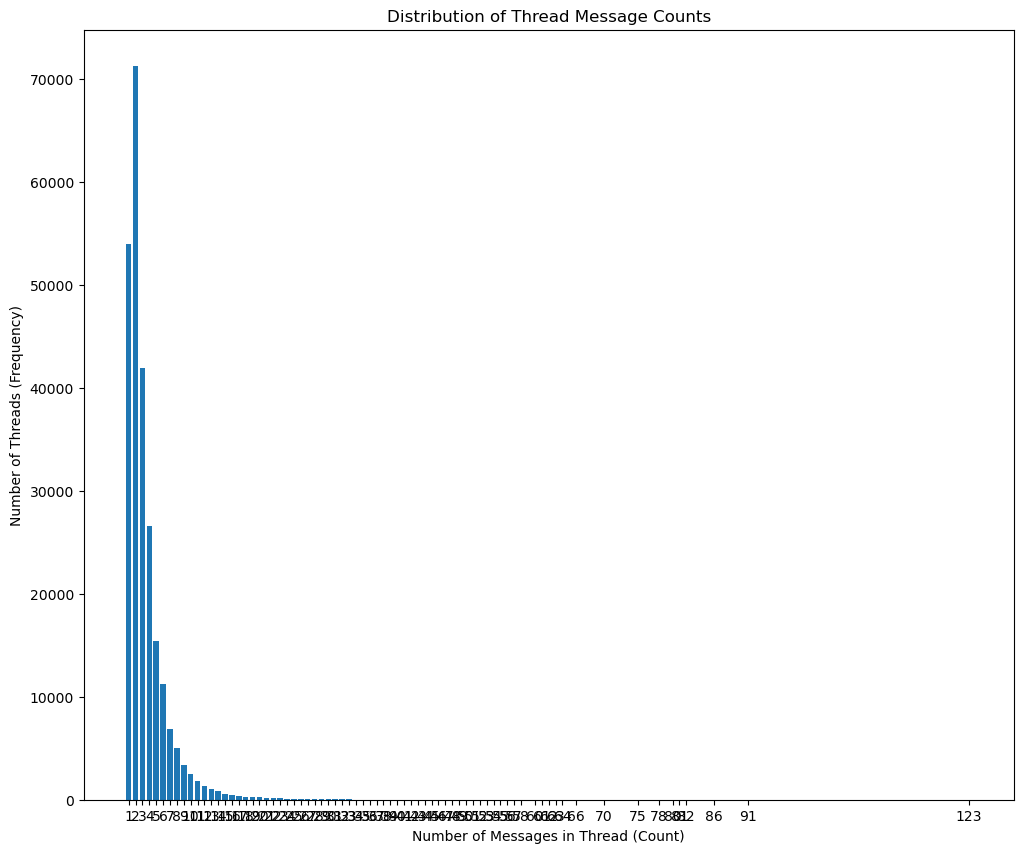

the number of threads is 246588
the number of messages is 848790
 the average number of messages per thread is 3.4421383035670834


In [46]:
# Get the count of each Thread ID
thread_counts = data_sample['Thread ID'].value_counts()
# Now, get the frequency of each count (i.e., how many threads have count=1, count=2, etc.)
count_frequency = thread_counts.value_counts().sort_index()

# Plot
plt.figure(figsize=(12,10))
plt.bar(count_frequency.index, count_frequency.values)
plt.xlabel('Number of Messages in Thread (Count)')
plt.ylabel('Number of Threads (Frequency)')
plt.title('Distribution of Thread Message Counts')
plt.xticks(count_frequency.index)  # Show all counts on x-axis if not too many
plt.show()
print(f"the number of threads is {len(thread_counts)}")
print(f"the number of messages is {thread_counts.sum()}")
print(f" the average number of messages per thread is {thread_counts.mean()}")


#### Focus on valid question-answer pair

In [157]:
def remove_duplicate_messages(threads_to_keep):
    # first round of duplicate removal
    df = data_sample_sub_cols[data_sample_sub_cols['Thread ID'].isin(threads_to_keep)].reset_index().sort_values(['Thread ID', 'index'], ascending=False).drop_duplicates()
 
    # Create a boolean column: True if response exists, False otherwise
    df['has_response'] = df["Actual Response Sent to Patient"].notnull()

    # Sort so that for each Patient Message, rows with a response come first, then by index (descending or ascending as you prefer)
    df = df.sort_values(['Patient Message', 'has_response', 'index'], ascending=[True, False, False])

    # Drop duplicates based on Patient Message, keeping the one with a response if it exists
    df_no_dupes = df.drop_duplicates(subset=["Patient Message"], keep='first').sort_values(['Thread ID', 'index'], ascending=False)

    # Optionally, drop the helper column
    df_no_dupes = df_no_dupes.drop(columns=['has_response'])
    return df_no_dupes


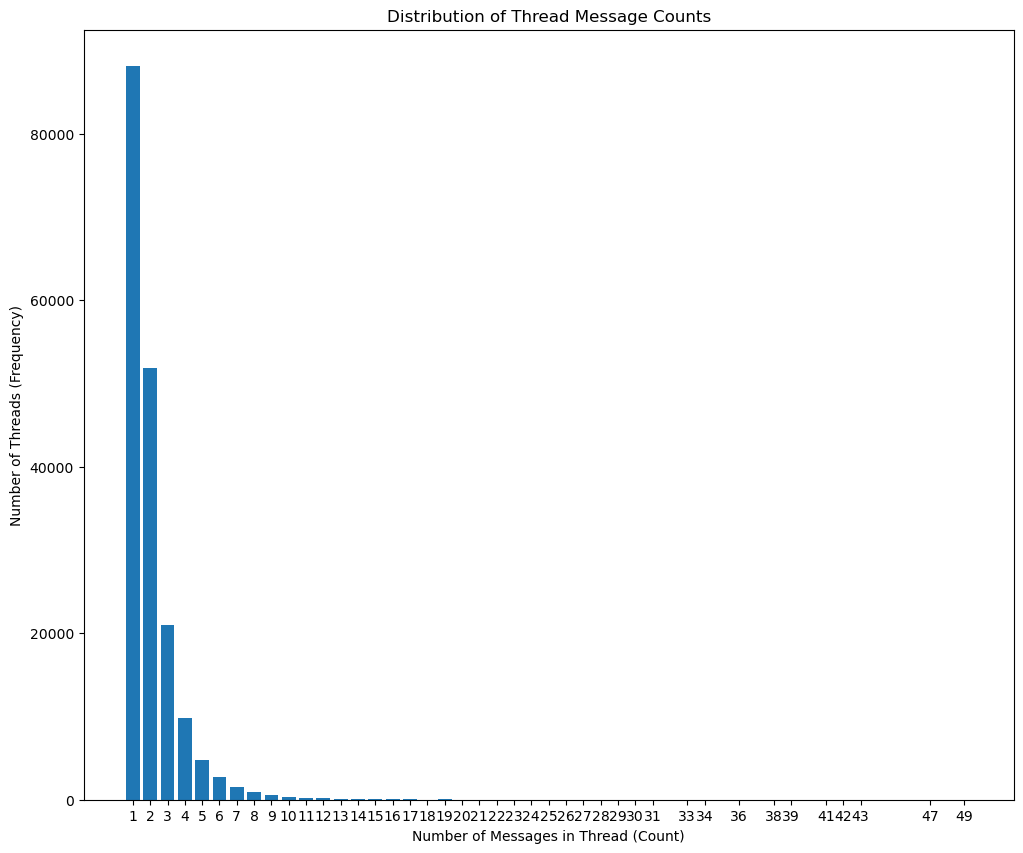

the number of threads is 182698
the number of messages is 375933
 the average number of messages per thread is 2.0576744135130105


In [ ]:
# Get the count of each Thread ID
# Filter out rows where patient message and actual response are not present
threads_to_keep = data_sample_sub_cols[data_sample_sub_cols["Actual Response Sent to Patient"].notna()]["Thread ID"].unique()
answer_question_paired_data_dedup = remove_duplicate_messages(threads_to_keep = threads_to_keep).dropna(subset=["Patient Message"]) # the main df for embedding
answer_question_paired_data_dedup["Patient Message"] = answer_question_paired_data_dedup["Patient Message"].str.replace("<13><10>", "")
answer_question_paired_data_dedup["Actual Response Sent to Patient"] = answer_question_paired_data_dedup["Actual Response Sent to Patient"].str.replace("<13><10>", "")
thread_counts_with_response = answer_question_paired_data_dedup['Thread ID'].value_counts()

# Now, get the frequency of each count (i.e., how many threads have count=1, count=2, etc.)
count_frequency_with_response = thread_counts_with_response.value_counts().sort_index()

# Plot
plt.figure(figsize=(12,10))
plt.bar(count_frequency_with_response.index, count_frequency_with_response.values)
plt.xlabel('Number of Messages in Thread (Count)')
plt.ylabel('Number of Threads (Frequency)')
plt.title('Distribution of Thread Message Counts')
plt.xticks(count_frequency_with_response.index)  # Show all counts on x-axis if not too many
plt.show()
print(f"the number of threads is {len(thread_counts_with_response)}")
print(f"the number of messages is {thread_counts_with_response.sum()}")
print(f" the average number of messages per thread is {thread_counts_with_response.mean()}")

In [ ]:
# save the df to box: has permission trouble
# path_to_save = "/Users/wenyuanchen/Library/CloudStorage/Box-Box/ART_PerMessage_1_17_Updated_dedup_embedding.xlsx"
# answer_question_paired_data_dedup.to_excel(path_to_save, index=True)
# answer_question_paired_data_dedup.to_excel("../data/answer_question_paired_data_dedup.xlsx", index=True)


there are 3791 unique recipient each with average 68.06963861777895 threads


<Axes: xlabel='Recipient Names'>

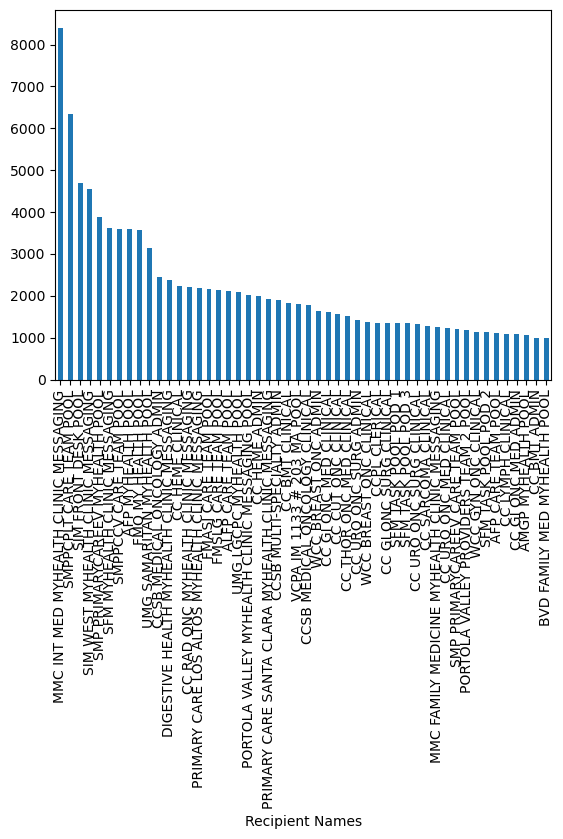

In [291]:
stats = answer_question_paired_data_dedup.groupby("Recipient Names")["Thread ID"].nunique()
print(f"there are {len(stats)} unique recipient each with average {np.mean(stats.values)} threads")
stats.sort_values(ascending=False)[:50].plot(kind="bar")

there are 104 unique department, each with average 1756.8365384615386 threads


<Axes: xlabel='Message Department'>

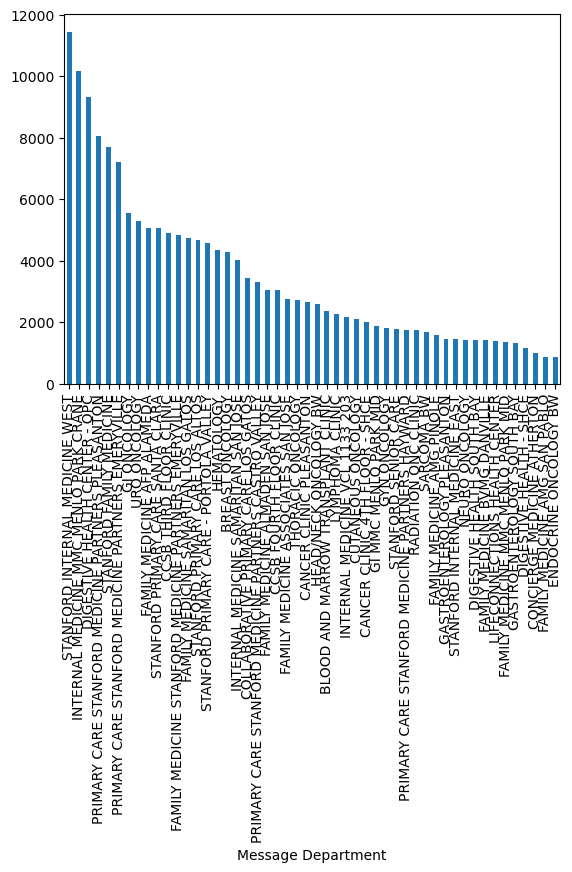

In [293]:
stats = answer_question_paired_data_dedup.groupby("Message Department")["Thread ID"].nunique()
print(f"there are {len(stats)} unique department, each with average {np.mean(stats.values)} threads")
stats.sort_values(ascending=False)[:50].plot(kind="bar")

there are 11 unique specialties, each with average 16609.272727272728 threads


<Axes: xlabel='Department Specialty Title'>

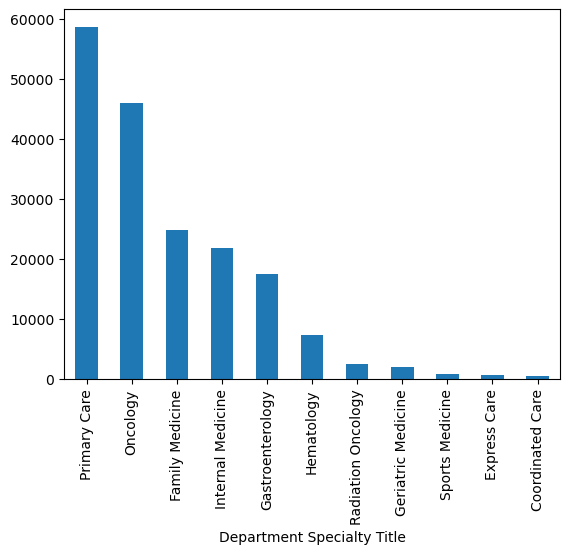

In [292]:
stats = answer_question_paired_data_dedup.groupby("Department Specialty Title")["Thread ID"].nunique()
print(f"there are {len(stats)} unique specialties, each with average {np.mean(stats.values)} threads")
stats.sort_values(ascending=False)[:50].plot(kind="bar")

<BarContainer object of 114 artists>

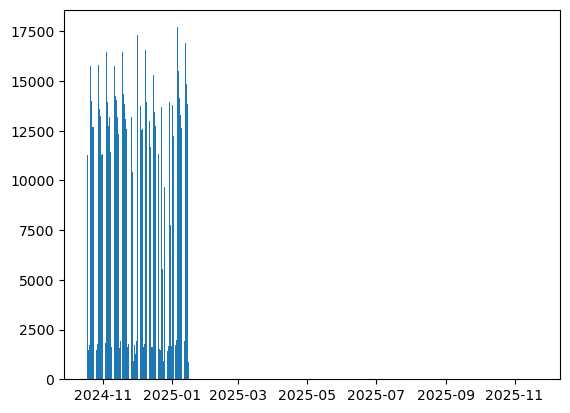

In [245]:
no_outlier = data_sample_sub_cols[data_sample_sub_cols["Date Sent"] != data_sample_sub_cols["Date Sent"].max()]
plt.bar(no_outlier["Date Sent"].value_counts().index, no_outlier["Date Sent"].value_counts().values)
#this means messages span only 3 months

#### embedding starts

In [8]:
def create_embeddings():
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"
    )
    return embeddings
embeddings_model = create_embeddings()

In [ ]:
# Create embeddings for all texts
texts = answer_question_paired_data_dedup["Patient Message"].str.replace("<13><10>", "").tolist()
embeddings = embeddings_model.embed_documents(texts)
# Save embeddings
# np.save("../data/embeddings.npy", np.array(embeddings))
answer_question_paired_data_dedup["embeddings"] = embeddings
# Make sure the embeddings column is a list of float64 per row
answer_question_paired_data_dedup["embeddings"] = answer_question_paired_data_dedup["embeddings"].apply(lambda x: [float(val) for val in x])

In [ ]:
# dataset_id = "rag_embedding_R01"
# dataset_ref = client.dataset(dataset_id)

# # Create the dataset
# dataset = bigquery.Dataset(dataset_ref)
# dataset.location = "US" 

# client.create_dataset(dataset, exists_ok=True)
# print(f"✅ Created dataset: {dataset_id}")

# upload the embedding with meta data to gcp big query
table_id = "som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings"

schema = [
    bigquery.SchemaField("index", "INT64"),
    bigquery.SchemaField("Thread ID", "INT64"),
    bigquery.SchemaField("Date Sent", "TIMESTAMP"),
    bigquery.SchemaField("Subject", "STRING"),
    bigquery.SchemaField("Patient Message", "STRING"),
    bigquery.SchemaField("Message Sender", "STRING"),
    bigquery.SchemaField("Actual Response Sent to Patient", "STRING"),
    bigquery.SchemaField("Recipient Names", "STRING"),
    bigquery.SchemaField("Recipient IDs", "STRING"),
    bigquery.SchemaField("Message Department", "STRING"),
    bigquery.SchemaField("Department Specialty Title", "STRING")

    bigquery.SchemaField("embeddings", "FLOAT64", mode="REPEATED")
    
]

job_config = bigquery.LoadJobConfig(
    schema=schema,
    write_disposition="WRITE_TRUNCATE",
    clustering_fields=["Recipient Names", "Message Department", "Department Specialty Title"]
)

job = client.load_table_from_dataframe(answer_question_paired_data_dedup, table_id, job_config=job_config)
job.result()

print("✅ Upload complete with clustering.")


# test query

In [15]:
import requests
import json
from dotenv import load_dotenv
load_dotenv()
import os


my_key = os.getenv("HEALTHREX_API_KEY")
random_idx = np.random.randint(0, len(answer_question_paired_data_dedup))
query_message = answer_question_paired_data_dedup.iloc[random_idx]["Patient Message"]
print(answer_question_paired_data_dedup.iloc[random_idx])
my_question = f"""You are a patient with similar symptoms to the patient who asked this question: "{query_message}"

Please generate a new question that:
1. Covers similar medical concerns but uses different wording and phrasing
2. Includes some personal context or specific details that make it feel more natural
3. May mention different but related symptoms or concerns
4. Uses a more conversational tone

Your question should sound like it's coming from a different person, not just a rephrasing of the original question. 
Focus on the underlying medical concern but express it in your own words."""
# Common Headers (Used for all models)
headers = {'Ocp-Apim-Subscription-Key': my_key, 'Content-Type': 'application/json'}

index                                                                         341408
Thread ID                                                                  252160980
Date Sent                                                        2024-12-04 00:00:00
Subject                                                          Scheduling Question
Patient Message                    Hi Dr. Martin,<13><10>I hope you're well! <13>...
Message Sender                                            APOSTOL, JENNY [ S0333370]
Actual Response Sent to Patient    Barbara, <13><10><13><10>No iron needed--the a...
Recipient Names                                                         MARTIN, BETH
Recipient IDs                                                               S0050381
Message Department                                                        HEMATOLOGY
Department Specialty Title                                                Hematology
Name: 161352, dtype: object


In [16]:
url = "https://apim.stanfordhealthcare.org/openai-eastus2/deployments/gpt-4.1/chat/completions?api-version=2025-01-01-preview" 
payload = json.dumps({
    "model": "gpt-4.1", 
    "messages": [{"role": "user", "content": my_question}]
})
response = requests.request("POST", url, headers=headers, data=payload)
message_content = response.json()["choices"][0]["message"]["content"]
print(message_content)

Hi Dr. Martin,

I wanted to touch base regarding my most recent blood work from earlier this month. I’ve been feeling extra fatigued and short of breath lately, and I’m a bit worried it might be related to my ongoing iron issues. Would you be able to let me know if my latest results suggest it’s time to schedule another iron infusion? Also, since I usually need an ultrasound-guided IV, should I go ahead and book that appointment too?

Thanks so much for your help!

Best,  
Melissa


##  ------------- strictest filter ---------
### all receiver, department and specialty exact match

In [17]:
from google.cloud import bigquery

query_message = message_content.replace("\n", "")
query_vector_literal = query_embedding_func(query_message, embeddings_model)
# query_vector = answer_question_paired_data_dedup.iloc[0]["embeddings"]
# Format the vector for BigQuery SQL
# query_vector_literal = str(query_vector).replace("[", "ARRAY[").replace("]", "]")

# Filter criteria 
receiver = answer_question_paired_data_dedup.iloc[random_idx]["Recipient Names"]
department = answer_question_paired_data_dedup.iloc[random_idx]["Message Department"]
specialty = answer_question_paired_data_dedup.iloc[random_idx]['Department Specialty Title']

query = f"""
WITH input_embedding AS (
  SELECT {query_vector_literal} AS input_vec
)

SELECT
  t.`Thread ID`,
  t.`Patient Message`,
  t.`Message Sender`,
  t.`Message Department`,
  t.`Department Specialty Title`,
  t.`Actual Response Sent to Patient`,
  (
    SELECT SUM(x * y)
    FROM UNNEST(t.embeddings) AS x WITH OFFSET i
    JOIN UNNEST(input_vec) AS y WITH OFFSET j
    ON i = j
  ) /
  (
    SQRT((SELECT SUM(POW(x, 2)) FROM UNNEST(t.embeddings) AS x)) *
    SQRT((SELECT SUM(POW(y, 2)) FROM UNNEST(input_vec) AS y))
  ) AS cosine_similarity
FROM `som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings` AS t,
     input_embedding
WHERE
  t.`Recipient Names` = @receiver
  AND t.`Message Department` = @department
  AND t.`Department Specialty Title` = @specialty
ORDER BY cosine_similarity DESC
LIMIT 5
"""

job = client.query(
    query,
    job_config=bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("receiver", "STRING", receiver),
            bigquery.ScalarQueryParameter("department", "STRING", department),
            bigquery.ScalarQueryParameter("specialty", "STRING", specialty)
        ]
    )
)
#  Show results
#  print(f"the input message {answer_question_paired_data_dedup.iloc[0]["Patient Message"]}")

# Debug: Print the query parameters
print("Query Parameters:")
print(f"query_message: {query_message}")
print(f"receiver: {receiver}")
print(f"department: {department}")
print(f"specialty: {specialty}")

# Debug: Try to get results
try:
    results = list(job.result())
    print(f"\nNumber of results: {len(results)}")
    
    if len(results) > 0:
        for row in results:
            print("##" * 80)
            print(f"✅ similarity: {row['cosine_similarity']:.4f}")
            print(f"Sender: {row['Message Sender']} -> the similar message of the whole thread : {row['Patient Message']}")
            print(f"Provider's response to this specific message in the thread: {row['Actual Response Sent to Patient']}")
            print("-----------printing the whole thread-------------")
            beatiful_print_thread(row["Thread ID"], answer_question_paired_data_dedup)
            print("##" * 80)
    else:
        print("No results found matching the criteria")
except Exception as e:
    print(f"Error getting results: {str(e)}")


Query Parameters:
query_message: Hi Dr. Martin,I wanted to touch base regarding my most recent blood work from earlier this month. I’ve been feeling extra fatigued and short of breath lately, and I’m a bit worried it might be related to my ongoing iron issues. Would you be able to let me know if my latest results suggest it’s time to schedule another iron infusion? Also, since I usually need an ultrasound-guided IV, should I go ahead and book that appointment too?Thanks so much for your help!Best,  Melissa
receiver: MARTIN, BETH
department: HEMATOLOGY
specialty: Hematology

Number of results: 5
################################################################################################################################################################
✅ similarity: 0.8124
Sender: APOSTOL, JENNY [ S0333370] -> the similar message of the whole thread : Hi Dr. Martin,I hope you're well! Did  you have an opportunity to review the labs my mom completed on 11/14/24?  If so, do you think she

## -----------Tiered Retrieval-----------

In [18]:
from google.cloud import bigquery

def run_query_bq(filter_field, filter_value, query_vector_literal, client, N, similarity_cutoff=0.7, exclude_threads=None):
    exclude_clause = ""
    params = [
        bigquery.ScalarQueryParameter("filter_value", "STRING", filter_value),
        bigquery.ScalarQueryParameter("similarity_cutoff", "FLOAT64", similarity_cutoff),
        bigquery.ScalarQueryParameter("N", "INT64", N)
    ]
    if exclude_threads and len(exclude_threads) > 0:
        # FIX: Cast to int and use INT64 type
        exclude_threads = [int(x) for x in exclude_threads]
        exclude_clause = "AND t.`Thread ID` NOT IN UNNEST(@exclude_threads)"
        params.append(bigquery.ArrayQueryParameter("exclude_threads", "INT64", exclude_threads))
    
    base_query = f"""
    WITH input_embedding AS (
      SELECT {query_vector_literal} AS input_vec
    ),
    scored_messages AS (
      SELECT
        t.`Thread ID`,
        t.`Patient Message`,
        t.`Message Sender`,
        t.`Message Department`,
        t.`Department Specialty Title`,
        t.`Actual Response Sent to Patient`,
        (
          SELECT SUM(x * y)
          FROM UNNEST(t.embeddings) AS x WITH OFFSET i
          JOIN UNNEST(input_vec) AS y WITH OFFSET j
          ON i = j
        ) /
        (
          SQRT((SELECT SUM(POW(x, 2)) FROM UNNEST(t.embeddings) AS x)) *
          SQRT((SELECT SUM(POW(y, 2)) FROM UNNEST(input_vec) AS y))
        ) AS cosine_similarity
      FROM `som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings` AS t, input_embedding
      WHERE t.`{filter_field}` = @filter_value
      {exclude_clause}
    )
    SELECT *
    FROM scored_messages
    WHERE cosine_similarity >= @similarity_cutoff
    ORDER BY cosine_similarity DESC
    LIMIT @N
    """

    job = client.query(
        base_query,
        job_config=bigquery.QueryJobConfig(query_parameters=params)
    )
    return list(job.result())


def run_tiered_retrieval(query_vector_literal, receiver, department, specialty, client, target_N=5, similarity_cutoff=0.7):
    all_results = []

    # 1. Sender Level
    results = run_query_bq(
        filter_field="Recipient Names", filter_value=receiver,
        query_vector_literal=query_vector_literal,
        client=client,
        N=target_N,
        similarity_cutoff=similarity_cutoff
    )
    all_results.extend([{**dict(r), "retrieval_tier": "sender"} for r in results])

    # 2. Department Level
    if len(all_results) < target_N:
        exclude_threads = [int(r["Thread ID"]) for r in all_results]
        results = run_query_bq(
            filter_field="Message Department", filter_value=department,
            query_vector_literal=query_vector_literal,
            client=client,
            N=target_N - len(all_results),
            similarity_cutoff=similarity_cutoff,
            exclude_threads=exclude_threads
        )
        all_results.extend([{**dict(r), "retrieval_tier": "department"} for r in results])

    # 3. Specialty Level
    if len(all_results) < target_N:
        exclude_threads = [int(r["Thread ID"]) for r in all_results]
        results = run_query_bq(
            filter_field="Department Specialty Title", filter_value=specialty,
            query_vector_literal=query_vector_literal,
            client=client,
            N=target_N - len(all_results),
            similarity_cutoff=similarity_cutoff,
            exclude_threads=exclude_threads
        )
        all_results.extend([{**dict(r), "retrieval_tier": "specialty"} for r in results])

    return all_results[:target_N]


In [19]:
results = run_tiered_retrieval(
    query_vector_literal=query_vector_literal,
    receiver=receiver,
    department=department,
    specialty=specialty,
    client=client,
    target_N=10,                # Number of final results you want
    similarity_cutoff=0.7      # The minimum cosine similarity required
)


#show results
print("Query Parameters:")
print(f"query_message: {query_message}")
print(f"receiver: {receiver}")
print(f"department: {department}")
print(f"specialty: {specialty}")

try:
    print(f"\nNumber of results: {len(results)}")
    
    if len(results) > 0:
        for row in results:
            print("##" * 80)
            print(f"➡️ Similarity: {row['cosine_similarity']:.4f}")
            print(f"➡️ Message by Sender {row['Message Sender']}: {row['Patient Message']}")
            print(f"➡️ Provider's response to this specific message is: {row['Actual Response Sent to Patient']}")
            print(f"➡️ This result is from tier: {row['retrieval_tier']}")
            print("➡️ -----------printing the whole thread-------------")
            beatiful_print_thread(row["Thread ID"], answer_question_paired_data_dedup)
            print("##" * 80)
    else:
        print("No results found matching the criteria")
except Exception as e:
    print(f"Error getting results: {str(e)}")


Query Parameters:
query_message: Hi Dr. Martin,I wanted to touch base regarding my most recent blood work from earlier this month. I’ve been feeling extra fatigued and short of breath lately, and I’m a bit worried it might be related to my ongoing iron issues. Would you be able to let me know if my latest results suggest it’s time to schedule another iron infusion? Also, since I usually need an ultrasound-guided IV, should I go ahead and book that appointment too?Thanks so much for your help!Best,  Melissa
receiver: MARTIN, BETH
department: HEMATOLOGY
specialty: Hematology

Number of results: 10
################################################################################################################################################################
➡️ Similarity: 0.8124
➡️ Message by Sender APOSTOL, JENNY [ S0333370]: Hi Dr. Martin,I hope you're well! Did  you have an opportunity to review the labs my mom completed on 11/14/24?  If so, do you think she's due for an Iron Infusion a

## -----------Weighted Retrieval-----------

In [20]:
def get_personalized_score(row, receiver, department, specialty, 
                           sender_weight=0.2, dept_weight=0.1, spec_weight=0.05):
    score = row["cosine_similarity"]
    if row["Recipient Names"] == receiver:
        score += sender_weight
    elif row["Message Department"] == department:
        score += dept_weight
    elif row["Department Specialty Title"] == specialty:
        score += spec_weight
    return score

def weighted_retrieval(query_vector_literal, receiver, department, specialty, client, top_k=100, final_N=5,
                       sender_weight=0.2, dept_weight=0.1, spec_weight=0.05, similarity_cutoff=0.7):
    # Run the broad query
    base_query = f"""
    WITH input_embedding AS (
      SELECT {query_vector_literal} AS input_vec
    )
    SELECT
      t.`Thread ID`,
      t.`Patient Message`,
      t.`Message Sender`,
      t.`Recipient Names`,
      t.`Message Department`,
      t.`Department Specialty Title`,
      t.`Actual Response Sent to Patient`,
      (
        SELECT SUM(x * y)
        FROM UNNEST(t.embeddings) AS x WITH OFFSET i
        JOIN UNNEST(input_vec) AS y WITH OFFSET j
        ON i = j
      ) /
      (
        SQRT((SELECT SUM(POW(x, 2)) FROM UNNEST(t.embeddings) AS x)) *
        SQRT((SELECT SUM(POW(y, 2)) FROM UNNEST(input_vec) AS y))
      ) AS cosine_similarity
    FROM `som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings` AS t, input_embedding
    ORDER BY cosine_similarity DESC
    LIMIT @K
    """
    params = [bigquery.ScalarQueryParameter("K", "INT64", top_k)]
    job = client.query(
        base_query,
        job_config=bigquery.QueryJobConfig(query_parameters=params)
    )
    rows = list(job.result())

    # Compute personalized score for each row, filter by similarity_cutoff
    scored = []
    for r in rows:
        row_dict = dict(r)
        if row_dict["cosine_similarity"] >= similarity_cutoff:
            row_dict["personalized_score"] = get_personalized_score(
                row_dict, receiver, department, specialty, 
                sender_weight, dept_weight, spec_weight
            )
            # Annotate which tier matched
            if row_dict["Recipient Names"] == receiver:
                row_dict["personalization_tier"] = "sender"
            elif row_dict["Message Department"] == department:
                row_dict["personalization_tier"] = "department"
            elif row_dict["Department Specialty Title"] == specialty:
                row_dict["personalization_tier"] = "specialty"
            else:
                row_dict["personalization_tier"] = "none"
            scored.append(row_dict)

    # Sort by personalized_score (descending)
    scored = sorted(scored, key=lambda x: x["personalized_score"], reverse=True)

    # Return top N
    return scored[:final_N]


In [21]:
results = weighted_retrieval(
    query_vector_literal=query_vector_literal,
    receiver=receiver,
    department=department,
    specialty=specialty,
    client=client,
    top_k=100,
    final_N=5,  # Final results you want
    sender_weight=0.2,
    dept_weight=0.1,
    spec_weight=0.05,
    similarity_cutoff=0.7
)

#show results
print("Query Parameters:")
print(f"query_message: {query_message}")
print(f"receiver: {receiver}")
print(f"department: {department}")
print(f"specialty: {specialty}")

try:
    print(f"\nNumber of results: {len(results)}")
    
    if len(results) > 0:
        for row in results:
            print("##" * 80)
            print(f"[{row['personalization_tier']}] Score: {row['personalized_score']:.3f} (CosSim: {row['cosine_similarity']:.3f})")
            print(f"➡️ Message by Sender {row['Message Sender']}: {row['Patient Message']}")
            print(f"➡️ Provider's response to this specific message is: {row['Actual Response Sent to Patient']}")
            print(f"➡️ This result is from tier: {row['personalization_tier']}")
            print("➡️ -----------printing the whole thread-------------")
            beatiful_print_thread(row["Thread ID"], answer_question_paired_data_dedup)
            print("##" * 80)
    else:
        print("No results found matching the criteria")
except Exception as e:
    print(f"Error getting results: {str(e)}")


Query Parameters:
query_message: Hi Dr. Martin,I wanted to touch base regarding my most recent blood work from earlier this month. I’ve been feeling extra fatigued and short of breath lately, and I’m a bit worried it might be related to my ongoing iron issues. Would you be able to let me know if my latest results suggest it’s time to schedule another iron infusion? Also, since I usually need an ultrasound-guided IV, should I go ahead and book that appointment too?Thanks so much for your help!Best,  Melissa
receiver: MARTIN, BETH
department: HEMATOLOGY
specialty: Hematology

Number of results: 5
################################################################################################################################################################
[sender] Score: 1.012 (CosSim: 0.812)
➡️ Message by Sender APOSTOL, JENNY [ S0333370]: Hi Dr. Martin,I hope you're well! Did  you have an opportunity to review the labs my mom completed on 11/14/24?  If so, do you think she's due for an 